# Bonus: ParmEst with Two Datasets

We have already estimated the four parameters ($U_a$, $U_b$, $C_p^H$, $C_p^S$) in the TCLab model using the [step test data](../notebooks/parmest_exercise.ipynb) and [sine test data](../notebooks/parmest.ipynb).

Can we use ParmEst to estimate these parameters using both data sets simultanously? Yes, we can! Let's see the syntax below.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TC_Lab_data,
    TC_Lab_experiment,
    extract_results,
    extract_plot_results,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data (step test)

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'
df_step = pd.read_csv(file)
df_step.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.84,50.0,0.0
1,1.00,22.84,22.84,50.0,0.0
2,2.01,23.16,22.84,50.0,0.0
3,3.02,22.84,22.84,50.0,0.0
4,4.01,22.84,22.84,50.0,0.0


Make two plots to visualize the temperature and heat power data as a function of time.

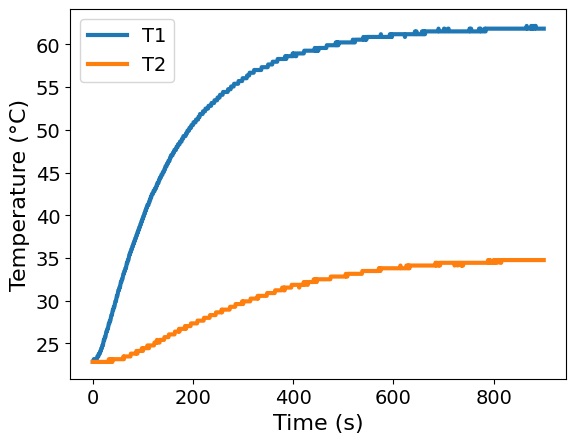

In [3]:
ax = df_step.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')


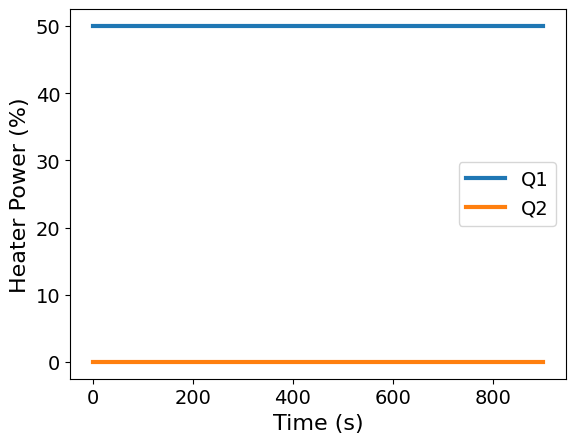

In [4]:
ax = df_step.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

We'll now store the data in this custom *data class* objective. This is a nice trick to help keep data organized, but it is NOT required to use ParmEst or Pyomo data. Alternatively, we could just use a pandas DataFrame.

In [5]:
def df_to_dataclass(df):
    tc_data = TC_Lab_data(
        name="Sine Wave Test for Heater 1",
        time=df['Time'].values,
        T1=df['T1'].values,
        u1=df['Q1'].values,
        P1=200,
        TS1_data=None,
        T2=df['T2'].values,
        u2=df['Q2'].values,
        P2=200,
        TS2_data=None,
        Tamb=df['T1'].values[0],
    )
    return tc_data

tc_data_step = df_to_dataclass(df_step)

Our custom data class has a method to export the data as a Pandas Data Frame.

In [6]:
tc_data_step.to_data_frame().head()

,time,T1,u1,P1,TS1_data,T2,u2,P2,TS2_data,Tamb
0,0.00,22.84,50.0,200,None,22.84,0.0,200,None,22.84
1,1.00,22.84,50.0,200,None,22.84,0.0,200,None,22.84
2,2.01,23.16,50.0,200,None,22.84,0.0,200,None,22.84
3,3.02,22.84,50.0,200,None,22.84,0.0,200,None,22.84
4,4.01,22.84,50.0,200,None,22.84,0.0,200,None,22.84


## Load and explore experimental data (sine test)

In [7]:
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test_5min_period.csv"
else:
    file = '../data/tclab_sine_test_5min_period.csv'
df_sine = pd.read_csv(file)
df_sine.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.2,22.2,50,0
1,1.01,22.2,22.2,51,0
2,2.01,22.2,22.2,52,0
3,3.00,22.2,22.2,53,0
4,4.01,22.2,22.2,54,0


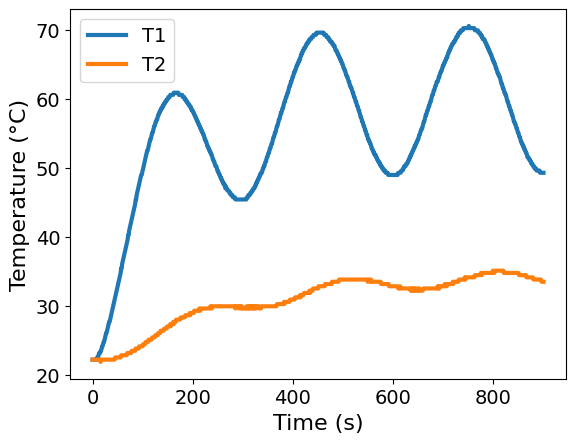

In [8]:
ax = df_sine.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')


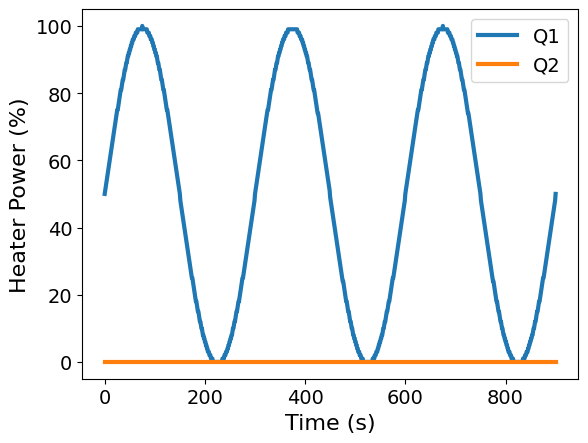

In [9]:
ax = df_sine.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In [10]:
tc_data_sine = df_to_dataclass(df_sine)

## Parameter estimation with ParmEst

Now for the main event: performing nonlinear least squares with `ParmEst`. For multiple datasets, we just need to give `ParmEst` a list of dictionaries or pandas dataframes where each entry is an experiment. It's that easy.



In [11]:
import pyomo.contrib.parmest.parmest as parmest

# First, we need to define both experiments
TC_Lab_sine_exp = TC_Lab_experiment(data=tc_data_sine, number_of_states=number_tclab_states)
TC_Lab_step_exp = TC_Lab_experiment(data=tc_data_step, number_of_states=number_tclab_states)

# Since everything has been labeled properly in the Experiment object, we simply invoke
# parmest's Estimator function to estimate the parameters on the list of experiments!
pest = parmest.Estimator([TC_Lab_sine_exp, TC_Lab_step_exp, ], obj_function='SSE', tee=True)

obj, theta = pest.theta_est()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [12]:
print("Estimated parameters:")
print(theta)

Estimated parameters:
inv_CpH     0.163117
Ub          0.001638
Ua          0.041342
inv_CpS    35.197139
dtype: float64


**Discussion**: How do these results compare to our [previous analysis](../notebooks/parmest.ipynb)?

### Step Test Plotting

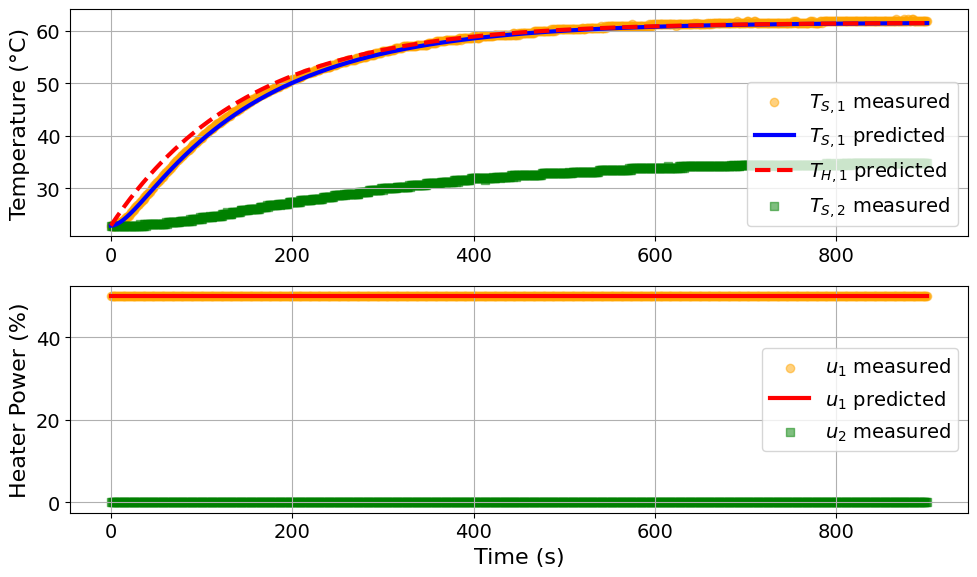

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0016 Watts/degC
CpH = 6.1306 Joules/degC
CpS = 0.0284 Joules/degC
 


In [13]:
parmest_regression_results = extract_plot_results(
    tc_data_step, pest.ef_instance.Scenario1
)

### Sine Test Plotting

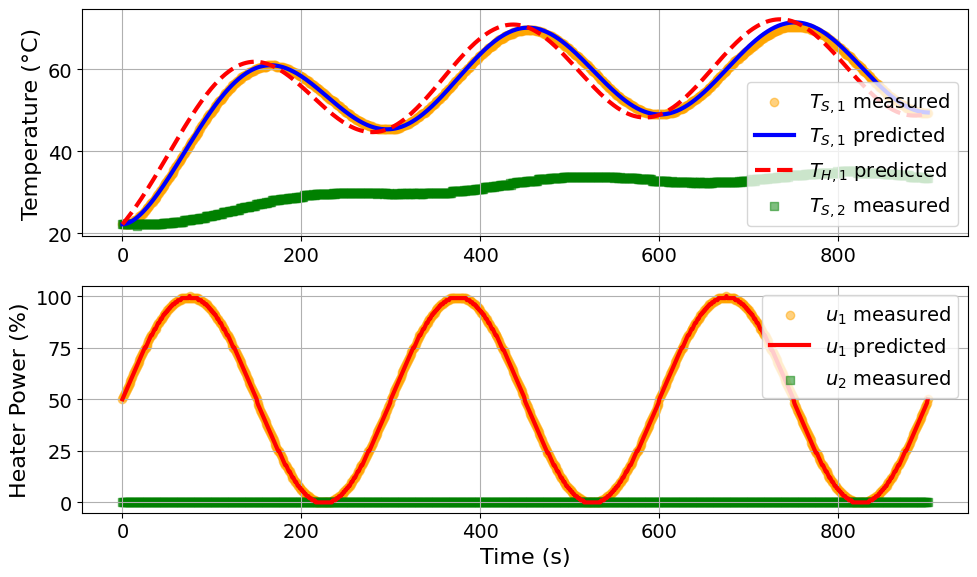

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0016 Watts/degC
CpH = 6.1306 Joules/degC
CpS = 0.0284 Joules/degC
 


In [14]:
parmest_regression_results = extract_plot_results(
    tc_data_sine, pest.ef_instance.Scenario0
)